In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import warnings, gc
import re

Using TensorFlow backend.


In [3]:
#functions
def multi_merge(left,right,*args):
    start = args[0]
    for i in range(1,len(args)):
        start = start.merge(args[i], how = 'left', left_on = left, right_on = right)
    return start

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type not in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

def clean_data(df,year):
    column_list = list(df.columns)
    A_list = [column for column in column_list if re.match(r'^[A][0-9]{2,10}',column) or re.match(r'^[a][0-9]{2,10}',column)]
    N_list = [column for column in column_list if re.match(r'^[N][0-9]{2,10}',column) or re.match(r'^[n][0-9]{2,10}',column)]
    O_list = [column for column in column_list if (column not in A_list and column not in N_list and column not in ['STATE','STATEFIPS','state','statefips'])]
    if 'n1' in O_list:
        N1 = 'n1'
    else:
        N1 = 'N1'
    special = []
    pair = []
    for name in A_list:
        if 'N' + name[1:] not in N_list and 'n' + name[1:] not in N_list:
            special.append(name)
        else:
            pair.append(name)
            if 'n' + name[1:] in N_list:
                pair.append('n' + name[1:])
            else:
                pair.append('N' + name[1:])
    special = O_list + special
    pair = pair + ['zipcode',N1]
    df_special = df.loc[:,special]
    df_pair = df.loc[:,pair]
    for column in list(df_special.columns):
        if column != 'zipcode':
            df_special[column] = df_special[column]/df_special[N1]
    df_special = df_special.groupby(by='zipcode').agg('mean')
    #print(df_special)
    for name in N_list:
        if name[0] == 'N':
            A_name = 'A' + name[1:]
        else:
            A_name = 'a' + name[1:]
        df_pair[A_name] = df_pair[A_name]/df_pair[name]
        df_pair[name] = df_pair[name]/df_pair[N1]
    #print(df_pair)
    df_pair = df_pair.groupby(by='zipcode').mean().drop(N1,axis=1)
    #print(df_pair)
    df_result = df_special.merge(df_pair,how='inner',left_on='zipcode',right_on='zipcode').drop([N1,'agi_stub'],axis=1)
    #print(df_pair.shape)
    #print(df_special.shape)
    #print(df_result.shape)
    result_name_list = [name  if name == 'zipcode' else name + '_' + year for name in list(df_result.columns)]
    df_result.columns = result_name_list
    return df_result

def normalization(x):
    min_x = min(x)
    max_x = max(x)
    return np.array([(i-min_x)/(max_x-min_x) for i in x])

def zscore_transformation(df):
    for name in df.columns:
        df[name] = zscore(df[name])
    return df.dropna(axis=1).dropna(axis=0)

Neural Network using one feature

In [23]:
df_cbp = pd.read_csv('./zbp16totals.csv')
df_2016 = pd.read_csv('./16zpallagi.csv')
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [24]:
df_cbp['est'] = zscore(df_cbp['est'])

In [25]:
df_train = df_train.merge(df_cbp,how='left',left_on='zipcode',right_on='zip')
df_test = df_test.merge(df_cbp,how='left',left_on='zipcode',right_on='zip')

In [27]:
df_train = df_train.loc[:,['est','score']]
df_test = df_test.loc[:,['est']]

In [30]:
x,y = to_xy(df_train,'score')

In [31]:
from keras import regularizers
kf = KFold(5)
oos_y = []
oos_pred = []
fold = 0
for train,test in kf.split(x):
    fold += 1
    print('Fold #{}'.format(fold))
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    activity_regularizer=regularizers.l1(0.01)))
    #model.add(Dense(75, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    #activity_regularizer=regularizers.l1(0.01)))
    #model.add(Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    #activity_regularizer=regularizers.l1(0.01)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=25, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="midterm_model1_best", verbose=0, save_best_only=True)
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=250)
    
    pred = model.predict(x_test)
    oos_y.append(y_test)
    oos_pred.append(pred)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = metrics.mean_squared_error(oos_pred,oos_y)
print("Final score (RMSE): {}".format(np.sqrt(score)))

Fold #1
Epoch 00217: early stopping
Fold score (RMSE): 0.26963096857070923
Fold #2
Epoch 00236: early stopping
Fold score (RMSE): 0.2748175263404846
Fold #3
Epoch 00249: early stopping
Fold score (RMSE): 0.2648850381374359
Fold #4
Fold score (RMSE): 0.2755565941333771
Fold #5
Epoch 00205: early stopping
Fold score (RMSE): 0.2741800844669342
Final score (RMSE): 0.2718437612056732


In [32]:
true_test = df_test.values.astype(np.float32)
pred_test = model.predict(true_test)
pred_test = model.predict(true_test)
final_test_score = np.concatenate(pred_test)

df_id = pd.read_csv('./test.csv')
df_id['score'] = final_test_score
df_id = df_id.loc[:,['id','score']]
df_id.to_csv('csv_to_submit_regularization.csv', index = False)

Adjusting some of the scores to integers

In [7]:
import copy
df_id_2 = copy.copy(df_id)
df_id_2['score'] = df_id_2['score'].apply(lambda x: x if 0.45<x-int(x) and x-int(x)<0.55 else np.round(x))
df_id_2.set_index('id',inplace = True)
df_id_2.to_csv('range_05.csv')
df_2016_result = clean_data(df_2016,'2016')
df_2016_result.shape

(29872, 142)

Neural Network with five features

In [11]:
df_2016 = clean_data(df_2016,'2016')
df_cbp = df_cbp.loc[:,['zip','emp','qp1','ap','est']]
df_2016_result = df_2016_result.merge(df_2016_business,how='left',left_on='zipcode',right_on='zip')
df_2016_result.head()

In [13]:
df_2016_result_2 = df_2016_result.fillna(0)
for name in df_2016_result_2.columns:
    if name != 'zip':
        df_2016_result_2[name] = normalization(df_2016_result_2[name])

In [14]:
df_2016_result_2.shape

(29872, 147)

In [ ]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train = df_train.merge(df_2016_result_2,how='left',left_on='zipcode',right_on='zip').drop(['id','zipcode','zip'],axis=1)
df_test = df_test.merge(df_2016_result_2,how='left',left_on='zipcode',right_on='zip').drop(['id','zipcode','zip'],axis=1)

In [27]:
df_train_sub = df_train.loc[:,['A00100_2016','emp','qp1','ap','est','score']]
df_test_sub = df_test.loc[:,['A00100_2016','emp','qp1','ap','est']]

In [28]:
x,y = to_xy(df_train_sub,'score')

In [17]:
df_test.head()

,mars1_2016,MARS2_2016,MARS4_2016,PREP_2016,N2_2016,NUMDEP_2016,TOTAL_VITA_2016,VITA_2016,TCE_2016,VITA_EIC_2016,...,A85300_2016,N85300_2016,A11901_2016,N11901_2016,A11902_2016,N11902_2016,emp,qp1,ap,est
0,0.039987,0.055645,0.014787,0.038045,0.049725,0.029456,0.000000,0.000000,0.0,0.0,...,0.008939,0.234375,0.064722,0.375671,0.009448,0.710278,0.004631,0.000568,0.000881,0.014254
1,0.009197,0.009608,0.008238,0.010402,0.011242,0.009186,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.044508,0.276923,0.008956,0.782949,0.000881,0.000117,0.000155,0.002193
2,0.002666,0.004003,0.000000,0.003853,0.001441,0.002330,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.006405,0.666667,0.000030,0.000009,0.000012,0.000685
3,0.012662,0.006805,0.005809,0.008668,0.007927,0.005159,0.006085,0.013575,0.0,0.0,...,0.055978,0.446429,0.132176,0.504042,0.011297,0.559206,0.019085,0.006599,0.007481,0.008498
4,0.011596,0.015853,0.003802,0.011847,0.013080,0.008987,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.056094,0.497667,0.008781,0.619012,0.001270,0.000145,0.000214,0.005208


In [29]:
from keras import regularizers
kf = KFold(5)
oos_y = []
oos_pred = []
fold = 0
for train,test in kf.split(x):
    fold += 1
    print('Fold #{}'.format(fold))
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    activity_regularizer=regularizers.l1(0.01)))
    #model.add(Dense(75, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    #activity_regularizer=regularizers.l1(0.01)))
    #model.add(Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                    #activity_regularizer=regularizers.l1(0.01)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=25, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="midterm_model1_best", verbose=0, save_best_only=True)
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=250)
    
    pred = model.predict(x_test)
    oos_y.append(y_test)
    oos_pred.append(pred)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = metrics.mean_squared_error(oos_pred,oos_y)
print("Final score (RMSE): {}".format(np.sqrt(score)))

Fold #1
Fold score (RMSE): 0.2908724844455719
Fold #2
Fold score (RMSE): 0.3195555508136749
Fold #3
Fold score (RMSE): 0.29362648725509644
Fold #4
Fold score (RMSE): 0.29371967911720276
Fold #5
Fold score (RMSE): 0.2938407063484192
Final score (RMSE): 0.2985142767429352


In [30]:
true_test = df_test_sub.values.astype(np.float32)
pred_test = model.predict(true_test)
pred_test = model.predict(true_test)
final_test_score = np.concatenate(pred_test)

df_id = pd.read_csv('./test.csv')
df_id['score'] = final_test_score
df_id = df_id.loc[:,['id','score']]
df_id.to_csv('csv_to_submit_regularization.csv', index = False)

Data Visualization

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_feature = pd.read_csv('./zbp16totals.csv')
df_train = df_train.merge(df_feature,how='left',left_on='zipcode',right_on='zip')
df_test = df_test.merge(df_feature,how='left',left_on='zipcode',right_on='zip')
df_train = df_train.loc[:,['score','emp','qp1','ap','est']]
df_test = df_test.loc[:,['emp','qp1','ap','est']]

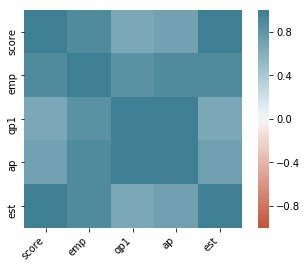

In [4]:
import seaborn as sns
corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [6]:
df_score_est = df_train.loc[:,['score','est']]
df_score_summary = df_score_est.groupby(by='score').apply(lambda x: pd.Series({'count':x.shape[0],\
                                                                               'min':min(x.est),\
                                                                               'max':max(x.est),\
                                                                               'range':max(x.est)-min(x.est)}))
df_score_summary.head(10)

,count,min,max,range
score,,,,
0,5467,1,14,13
1,4725,15,42,27
2,2097,43,70,27
3,1244,71,98,27
4,891,99,126,27
5,731,127,154,27
6,593,155,182,27
7,481,183,210,27
8,477,211,238,27
